In [1]:
# inline plotting

%matplotlib inline

In [2]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier

import seaborn as sns

# Fraud Detection

## Noto Practical Task For Classification

### Context

A small fintech company called AcmePay processes online 
payments in a risky business area. The compliance team uses a sophisticate fraud 
management tool based on rul. Itnd is already able to significantly reduce the fraud at t e
price of many rejected payments, but their ru es have become so complex that they are no
longer able to manage them. Despite that sophistication, a still significant amount of f aud
makes it through the rsiness.

### Problem To Solve

There is a need for development of a machine learning model that could reduce fraud levels and have good impact for the business.
It is important to have explainability of the results, as the business area is very sensitive. The total amount of flagged transactions should not exceed more than 2% of the total amount of all transactions.

### Data

We have one csv file containing 56 300 approved payments. It contains total 29 columns. 27 of them are strongly related to type of transactions. Second column represents amount of the transaction in euro.

- id: payment transaction id
- f_00 to f_26: the 27 features used from the compliance team in their rules
- fraud: the indicator showing if the payment turned out to be fraudulent (1) or not (0)

Let's load and have a look at our dataset. We need to get a sense of it before starting the real job.

In [3]:
# Read the csv file and check its shape

fraud_dataset = pd.read_csv('data/fraud_dataset.csv')

fraud_dataset.shape

(56300, 29)

In [4]:
# Have a look at first 5 rows of the dataset

fraud_dataset.head()

id      f_00     f_01       f_02          f_03         f_04  f_05 f_06  \
0   0    2000.0   0.5572   807554.0  5.908216e+10     Low risk   0.0   OH   
1   1   10000.0  23.7219   463706.0  1.780178e+10     Low risk   0.0   NY   
2   2   10000.0   4.2830  1412534.0  8.240876e+10     Low risk   0.0   NH   
3   3  100000.0  12.6532   790313.0  8.101635e+09  Medium risk   0.0   NY   
4   4     500.0   3.7086   695786.0  1.176408e+10     Low risk   0.0   OH   

           f_07     f_08  ...          f_18      f_19  f_20      f_21  \
0  7.848586e+11  10743.0  ...   1635.744444  0.002924   0.0  0.427777   
1  1.265205e+12   4889.0  ...  22444.444444  0.004840   0.0  1.766666   
2  1.072620e+12   6148.0  ...  21783.333333  0.001048   0.0  1.094444   
3  1.785177e+12  60120.0  ...    777.777777  0.000000   0.0  0.042657   
4  6.862985e+11  10951.0  ...   4862.000000  0.007334   0.0  3.476568   

       f_22      f_23  f_24  f_25          f_26  fraud  
0  0.811111    2500.0   0.0   NaN  5.908222e+10      0  
1  2.133333  115000.0   7.0   2.0  1.785006e+10      0  
2  3.566666   50500.0   3.0   1.0  8.240897e+10      0  
3  0.033333       0.0   0.0   NaN  8.101797e+09      0  
4  3.977777   85304.0   4.0   1.0  1.177989e+10      0  

[5 rows x 29 columns]

In [5]:
# Check for null values and data types

fraud_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56300 entries, 0 to 56299
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      56300 non-null  int64  
 1   f_00    56300 non-null  float64
 2   f_01    56300 non-null  float64
 3   f_02    56300 non-null  float64
 4   f_03    56300 non-null  float64
 5   f_04    56241 non-null  object 
 6   f_05    56273 non-null  float64
 7   f_06    56300 non-null  object 
 8   f_07    56300 non-null  float64
 9   f_08    54030 non-null  float64
 10  f_09    56273 non-null  float64
 11  f_10    56273 non-null  float64
 12  f_11    54477 non-null  float64
 13  f_12    56273 non-null  float64
 14  f_13    56273 non-null  float64
 15  f_14    17324 non-null  float64
 16  f_15    56273 non-null  float64
 17  f_16    56273 non-null  float64
 18  f_17    56273 non-null  float64
 19  f_18    56273 non-null  float64
 20  f_19    56273 non-null  float64
 21  f_20    56273 non-null  float64
 22

We see that 25 of the variables are type float64, two are of type int64 and two of the variables are categorical. We need to transform categorical values to numerical ones finding the most suitable transformation.

### Features investigation

Let's have a look at the population of both labels for fraud.

In [6]:
fraud_dataset.value_counts("fraud")

fraud
0    55848
1      452
Name: count, dtype: int64

It looks we will deal with a highly imbalanced dataset. Let's vizualize what is the target frequency.

In [7]:
def fraud_freq(dataset_name, f_name):
    """
    It calculates frequency by class name.
    """
    
    all = dataset_name[f_name].count()
    positive = dataset_name[f_name].sum()
    negative = all - positive
    
    print("Cases of fraud are: ", positive, ", which is ", '{:.0%}'.format(positive / all))
    print("Cases of approved payments are: ", negative, ", which is ", '{:.0%}'.format(negative / all))

In [8]:
def plot_freq(dataset_name, f_name):
    """
    It creates a pie chart in order to visualize the frequency by the class name chosen.
    """

    fraud_counts = dataset_name.groupby([f_name]).size().sort_values(ascending = True)

    plt.pie(fraud_counts 
            , labels = ["Fraud", "Approved"]
            , autopct='%1.0f%%'
            , colors = ["paleturquoise", "palegoldenrod"]
           )

    plt.title("Fraud Frequency")
    plt.gca().set_aspect("equal")
    plt.show()

In [9]:
fraud_freq(fraud_dataset, "fraud")

Cases of fraud are:  452 , which is  1%
Cases of approved payments are:  55848 , which is  99%


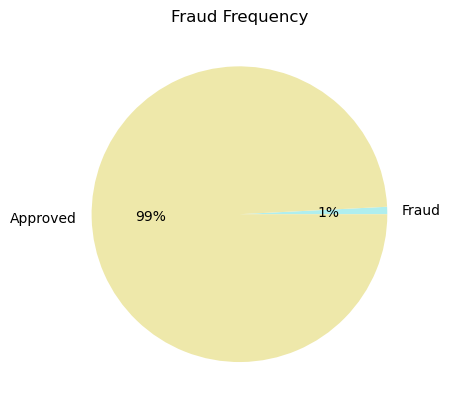

In [10]:
plot_freq(fraud_dataset, "fraud")

The total amount of fraudulent transactions is just 1% of all payments for this dataset. We need to find ways to deal properly with this imbalance. Let's check technics like syntetic oversampling and weights moving.

### Feature engeneering

Let's have a look at both categorical columns a bit closer.

In [11]:
# Show categorical values of column "f_04"

fraud_dataset.value_counts("f_04")

f_04
Low risk            45322
High risk            5810
Medium risk          3444
Low traffic bank     1665
Name: count, dtype: int64

We found 4 types of repeating values. They represent scale of risk and one value that describes a type of bank with low traffic. "Low traffic bank" value I am not sure whether it stands closer to low or high risk to get frauds. I would consult additionally with the compliance team on this. We need to get solid understanding of the business, as it only helps to improve data modeling.

As there is a concrete meaning in this variable we can use encoding from 0 to 3. 0 being "low traffic bank" and 3 being "high risk". Let's build a dictionary to accomplish this task.

In [12]:
# Build a dictionary and map categorical values to numerical ones 

f_04_dic = {"Low traffic bank": 0, "Low risk": 1, "Medium risk": 2, "High risk": 3 }
fraud_dataset["f_04"] = fraud_dataset["f_04"].map(f_04_dic)

Now let's take a look at the second feature "f_06".

In [13]:
# Show categorical values of column "f_06"

fraud_dataset.value_counts("f_06")

f_06
NY    7444
NJ    6443
CT    4896
IL    3827
PA    3813
OH    3429
MI    3375
MA    3212
AZ    2530
MD    1864
VA    1596
IN    1518
CO    1507
NC    1400
LA    1255
TN    1183
OR    1058
KY     837
NH     686
KS     600
IA     489
ME     452
WV     432
FL     376
CA     346
TX     290
MO     231
DC     148
GA     137
WA     133
RI     108
SC      99
VT      85
WI      74
DE      60
MS      51
MN      47
NV      47
WY      42
AL      29
NE      26
NM      23
UT      21
OK      15
SD      14
AR      14
ID       9
MT       7
HI       7
AS       5
ND       4
AK       3
AP       2
PR       1
Name: count, dtype: int64

In [14]:
# Let's check the number of unique values in column "f_06"

len(fraud_dataset["f_06"].unique())

54

It looks like we store here a post code of geo places. 

For column "f_06" if we do one hot encoding the size of the columns will increase significantly. And this will limit our further choice of data modeling algorithms. Let's generate a dictionary.

In [15]:
# Create a dictionary for feature "f_06"

f_06_dic = {"NY":1, "NJ":2, "CT":3, "IL":4, "PA":5, "OH":6, "MI":7, "MA":8, "AZ":9, "MD":10
            , "VA":11, "IN":12, "CO":13, "NC":14, "LA":15, "TN": 16, "OR":17, "KY":18, "NH":19, "KS":20
            , "IA":21, "ME":22, "WV":23, "FL":24, "CA":25, "TX":26, "MO":27, "DC":28, "GA":29, "WA":30
            , "RI":31, "SC":32, "VT":33, "WI":34, "DE":35, "MS":36, "MN":37, "NV":38, "WY":39, "AL":40
            , "NE":41, "NM":42, "UT":43, "OK":44, "SD":45, "AR":46, "ID":47, "MT":48, "HI":49, "AS":50
            , "ND":51, "AK":52, "AP":53, "PR":54}

fraud_dataset["f_06"] = fraud_dataset["f_06"].map(f_06_dic)

Let's have a look at the types once again to confirm we can further proceed and scale our data.

In [16]:
# Check dtypes of the whole dataset

fraud_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56300 entries, 0 to 56299
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      56300 non-null  int64  
 1   f_00    56300 non-null  float64
 2   f_01    56300 non-null  float64
 3   f_02    56300 non-null  float64
 4   f_03    56300 non-null  float64
 5   f_04    56241 non-null  float64
 6   f_05    56273 non-null  float64
 7   f_06    56300 non-null  int64  
 8   f_07    56300 non-null  float64
 9   f_08    54030 non-null  float64
 10  f_09    56273 non-null  float64
 11  f_10    56273 non-null  float64
 12  f_11    54477 non-null  float64
 13  f_12    56273 non-null  float64
 14  f_13    56273 non-null  float64
 15  f_14    17324 non-null  float64
 16  f_15    56273 non-null  float64
 17  f_16    56273 non-null  float64
 18  f_17    56273 non-null  float64
 19  f_18    56273 non-null  float64
 20  f_19    56273 non-null  float64
 21  f_20    56273 non-null  float64
 22

### Normalization

We need to see if data lives in several scales and get better understanding of it. Then we can choose suitable scaling formula.

Let's plot to visually inspect our first two features.

In [17]:
# Function to plot histogram

def plot_hist(dataset_column, n_bins = 5):
    plt.hist(dataset_column, n_bins)
    plt.semilogy()
    plt.show()

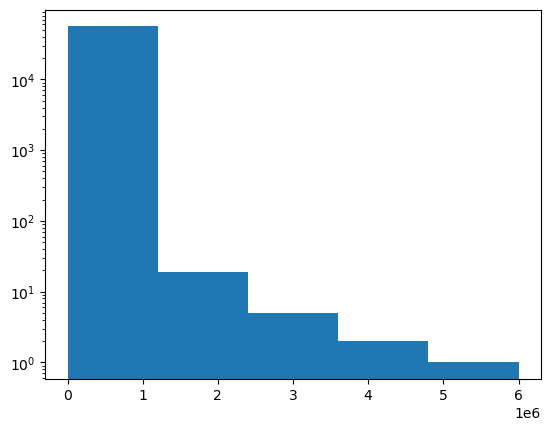

In [18]:
plot_hist(fraud_dataset["f_00"])

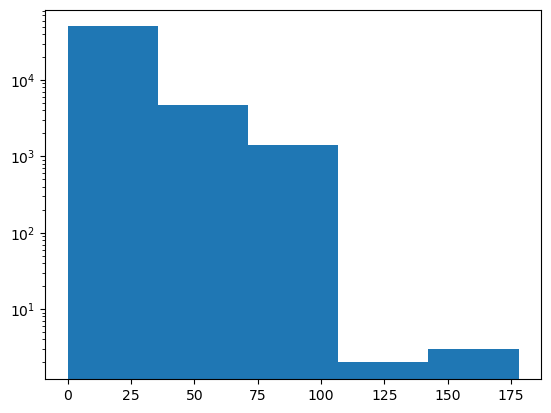

In [19]:
plot_hist(fraud_dataset["f_01"])

We see that for both columns data lives in too many different scales. In respect to this we can think of normalization using $\log$ or $\sqrt{x}$ transformation.

Let's have a look at the probabilities distributions of the same two features.

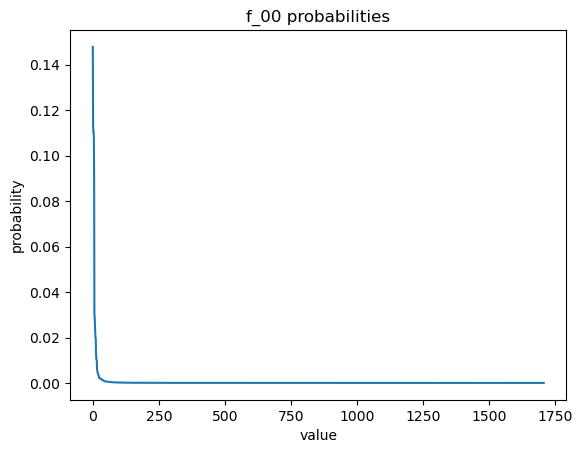

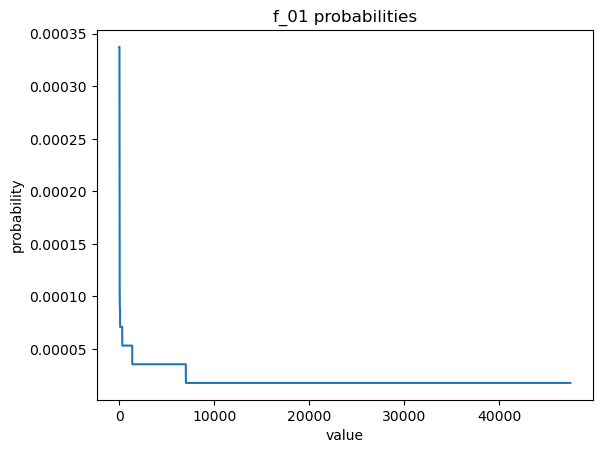

In [20]:
# Function to calculate frequentist probability

def prob(dataset):   
    num_el = len(dataset)
    val_counts = dataset.value_counts()
    probs = val_counts / num_el
    return probs

# Vizualize probabilities of the first feature
prob_f_00 = np.array(prob(fraud_dataset["f_00"]))

plt.plot(np.arange(0, len(prob_f_00)), prob_f_00)
plt.xlabel("value")
plt.ylabel("probability")
plt.title("f_00 probabilities")
plt.show()

# Vizualize probabilities of the second feature
prob_f_01 = np.array(prob(fraud_dataset["f_01"]))

plt.plot(np.arange(0, len(prob_f_01)), prob_f_01)
plt.xlabel("value")
plt.ylabel("probability")
plt.title("f_01 probabilities")
plt.show()

The distributions look to be exponential-like. 

These distributions together with the frequency distribution graphs guide us to choose $\log$ transformation before all others.

## Scale up the results

Let's scale up the data, as it looks like it lives in too many scales. We need to multiply the values with $\log$ with a base number of the parameters in the dataset. In my case, 29. I am using [change of base log rule](https://en.wikipedia.org/wiki/Logarithm#Change_of_base).

$$\log {_b} x = \frac {\log {_c} x} {\log {_c} b} $$

In [21]:
SEED = np.random.seed(11)

In [22]:
# Scaling the data

BASE = 29

data_transformed = np.where(fraud_dataset > 0.0000000001, fraud_dataset, 1)
data_scaled = np.log(data_transformed) / np.log(BASE)

data_scaled

array([[ 0.        ,  2.25727196, -0.17367973, ...,  0.        ,
         7.36561236,  0.        ],
       [ 0.        ,  2.7352335 ,  0.94033873, ...,  0.20584683,
         7.01015702,  0.        ],
       [ 0.20584683,  2.7352335 ,  0.43199462, ...,  0.        ,
         7.4644348 ,  0.        ],
       ...,
       [ 3.24842161,  2.94108034,  0.80557415, ...,  0.        ,
         7.50894273,  0.        ],
       [ 3.24842688,  3.00734822,  0.22104249, ...,  0.        ,
         7.44579757,  0.        ],
       [ 3.24843216,  2.05142513,  0.24728796, ...,  0.        ,
         6.8463027 ,  0.        ]])

In [23]:
# Check the range of the scaled data

data_scaled.min(), data_scaled.max()

(-2.27125695312213, 8.528127829089167)

### Train Test Split

Now it's time to split the dataset in portions. We need one bigger to train with and two smaller parts - to validate models and to test the chosen one.

In [24]:
# Here we split scaled and non-scaled data, as later we will need both to fulfill some compliance team requirements.

fraud_features = data_scaled[:, 0:28]
fraud_labels = fraud_dataset.fraud
fraud_f_non_scaled = fraud_dataset.drop(columns = ["fraud"])

In [25]:
# Check if labels look right

np.unique(fraud_labels)

array([0, 1], dtype=int64)

In [26]:
# Save global variable to ensure experiment reproducability

RANDOM_STATE = 11

# Make the actual split for scaled data

features_train, features_eval, labels_train, labels_eval = train_test_split(fraud_features, fraud_labels, test_size=0.35, random_state=RANDOM_STATE)

features_val, features_test, labels_val, labels_test = train_test_split(features_eval, labels_eval, test_size=0.5, random_state=RANDOM_STATE)

In [27]:
# Get the whole split again for the dataset without scaling

f_train, f_eval, l_train, l_eval = train_test_split(fraud_f_non_scaled, fraud_labels, test_size=0.35, random_state=RANDOM_STATE)

f_val, f_test, l_val, l_test = train_test_split(f_eval, l_eval, test_size=0.5, random_state=RANDOM_STATE)

Let's check the shapes we get for train, validation and test for the scaled data.

In [28]:
# Check features shapes

len(features_train), len(features_val), len(features_test)

(36595, 9852, 9853)

In [29]:
#Check labels shapes

len(labels_train), len(labels_val), len(labels_test)

(36595, 9852, 9853)

### Oversampling

I decided to use a technique for oversampling, as undersampling is not an option with our dataset and the type of the data. 

SMOTE or Synthetic Minority Oversampling Technique is designed to tackle imbalanced datasets by generating synthetic samples for the minority class. It works based on the KNN algorithm.

In [30]:
# Resampling the minority class

sm = SMOTE(sampling_strategy = "minority", random_state = RANDOM_STATE)

# Fit the model to generate the data

oversampled_features, oversampled_labels = sm.fit_resample(features_train, labels_train)

In [31]:
# Check oversampled sets' shapes

oversampled_features.shape, oversampled_labels.shape

((72574, 28), (72574,))

### Algorithm

#### Decision Tree

Let's build a model wuth Decision Tree Classifier. We will use the oversampled datasets. 

Through out some experiments we see that best performance on the validation set we get with max_depth 15.

In [32]:
# Building our Decision Tree

tree = DecisionTreeClassifier(criterion = "gini", splitter = "best", max_depth = 15, random_state = RANDOM_STATE)

In [33]:
tree.fit(oversampled_features, oversampled_labels)

DecisionTreeClassifier(max_depth=15, random_state=11)

In [34]:
predictions_tree = tree.predict(features_val)

#### Evaluation

In [35]:
cv_scores_tree = cross_val_score(tree, features_train, labels_train, cv = 3)
cv_scores_tree

array([0.98672022, 0.98598131, 0.98753894])

In [36]:
tree.score(features_val, labels_val)

0.9579780755176613

#### Random Forest

Let's buil a random forest. We will use the oversampled data.

In [37]:
rf = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE)

rf.fit(oversampled_features, oversampled_labels)

RandomForestClassifier(n_estimators=50, random_state=11)

In [38]:
predictions_rf = rf.predict(features_val)

#### Evaluation Metrics

In [39]:
cv_scores_rf = cross_val_score(rf, features_train, labels_train, cv=3)
cv_scores_rf

array([0.99155668, 0.99163797, 0.99163797])

In [40]:
rf.score(features_val, labels_val)

0.9899512789281364

#### Balanced Random Forest

Another algorithm that it's worth trying is Balanced Random Forest. It is specifically designed to address imbalanced datasets.

In [41]:
brf = BalancedRandomForestClassifier(
    n_estimators=32,
    sampling_strategy="all",
    replacement=True,
    bootstrap=False,
    random_state=RANDOM_STATE,
)
brf.fit(features_train, labels_train)

BalancedRandomForestClassifier(bootstrap=False, n_estimators=32,
                               random_state=11, replacement=True,
                               sampling_strategy='all')

In [42]:
predictions_brf = brf.predict(features_val)

#### Evaluation Metrics

In [43]:
cv_scores_brf = cross_val_score(brf, features_train, labels_train, cv=3)
cv_scores_brf

array([0.87343225, 0.87809477, 0.87858665])

In [44]:
brf.score(features_val, labels_val)

0.871396670726756

### Other Evaluation Metrics

#### Classification report

In [45]:
labels_names = ["non-fraud", "fraud"]

In [46]:
print("Decision Tree " + classification_report(labels_val, predictions_tree))
print("Random Forest " + classification_report(labels_val, predictions_rf))
print("Balanced Random Forest" + classification_report(labels_val, predictions_brf))

Decision Tree               precision    recall  f1-score   support

           0       0.99      0.96      0.98      9781
           1       0.04      0.20      0.06        71

    accuracy                           0.96      9852
   macro avg       0.52      0.58      0.52      9852
weighted avg       0.99      0.96      0.97      9852

Random Forest               precision    recall  f1-score   support

           0       0.99      1.00      0.99      9781
           1       0.17      0.10      0.12        71

    accuracy                           0.99      9852
   macro avg       0.58      0.55      0.56      9852
weighted avg       0.99      0.99      0.99      9852

Balanced Random Forest              precision    recall  f1-score   support

           0       1.00      0.87      0.93      9781
           1       0.03      0.59      0.06        71

    accuracy                           0.87      9852
   macro avg       0.51      0.73      0.50      9852
weighted avg       0.99 

Let's have a look at the models' performance based on precision, recall and F1. We focus on predictions for fraudulent events.

##### Decision Tree
Precision: Out of all frauds that the model predicted, only 0.4% were real frauds.

Recall: Out of all frauds that really happened the model only predicted 20% of them.

F1: We see very poor performance for fraudulent predictions - score 0.06.

##### Random Forest
Precision: Out of all frauds that the model predicted, only 17% were real frauds.

Recall: Out of all frauds that really happened the model only predicted 10% of them.

F1: We see very poor performance for fraudulent predictions - score 0.12.

##### Balanced Random Forest
Precision: Out of all frauds that the model predicted, only 0.3% were real frauds.

Recall: Out of all frauds that really happened the model predicted 59% of them.

F1: We see very poor performance for fraudulent predictions - score 0.06.

#### Classes Histogram

In [47]:
def display_residuals(actual_set_name, prediction_set_name, title):
    """
    Function to display residual histogram.
    
    Parameters:
    actual_set_name - dataset name with actuals
    prediction_set_name - dataset name with predictions
    title - title of the diagram
    """
    
    plt.hist(actual_set_name, color = "c", alpha = 0.7, label = "Actuals")
    plt.hist(prediction_set_name, color = "y", alpha = 0.7, label = "Predictions")

    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Frequency")
    plt.xticks([-1, 0, 1])
    plt.ylim(0, 10000)
    # plt.semilogy()
    plt.legend()

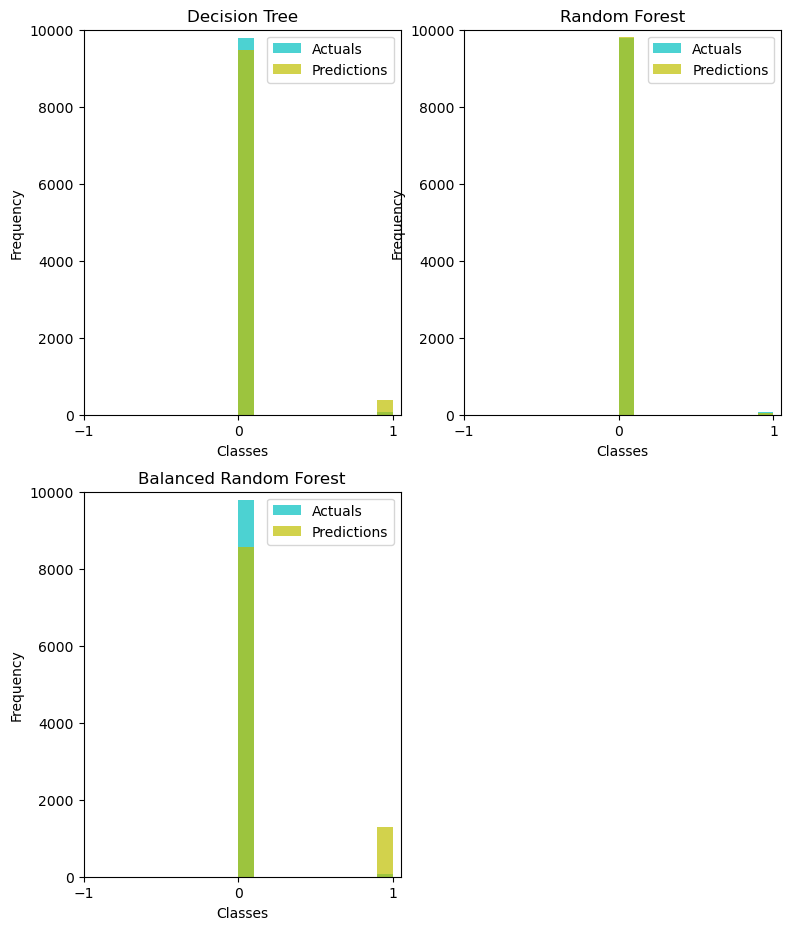

In [48]:
fig = plt.figure(figsize = (9, 11))
rows, cols = 2, 2

fig.add_subplot(rows, cols, 1)
display_residuals(labels_val, predictions_tree, "Decision Tree")

fig.add_subplot(rows, cols, 2)
display_residuals(labels_val, predictions_rf, "Random Forest")

fig.add_subplot(rows, cols, 3)
display_residuals(labels_val, predictions_brf, "Balanced Random Forest")

plt.show()

These are the visual representation of actual and predicted payments per label (0 and 1).

It is clear that Balanced Random Forest is overfitting the fradulent payments and flagges much more than needed.

#### Confusion Matrix

Let's get confused with some Confusion Matrices.

In [49]:
def make_cm_df(predictions):
    cm_name = confusion_matrix(labels_val, predictions)
    cm_df = pd.DataFrame(cm_name, index = labels_names, columns = labels_names)
    return cm_df

In [50]:
def visualize_cm(data, title):
    """
    Plots a Confusion Matrix.
    
    Parameters:
    data - dataset name
    title - title for the matrix
    """
    sns.heatmap(data
            , annot = True
            , fmt = "g"
            , cmap = "crest"
           )
    plt.ylabel("Prediction", fontsize = 13)
    plt.xlabel("Actual", fontsize = 13)
    plt.title(title, fontsize = 17)
    plt.show()

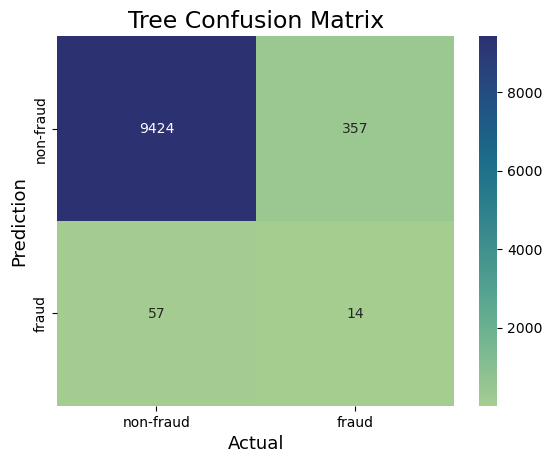

In [51]:
visualize_cm(make_cm_df(predictions_tree), "Tree Confusion Matrix")

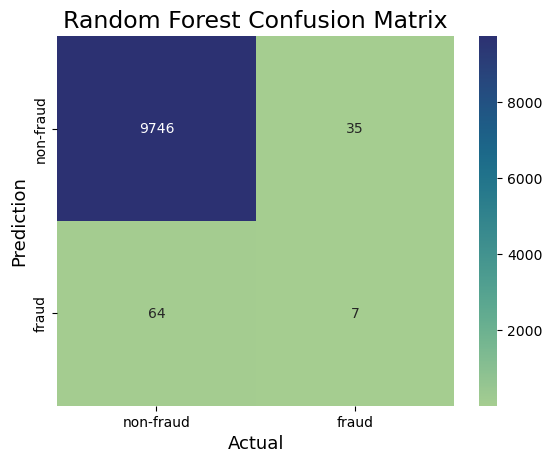

In [52]:
visualize_cm(make_cm_df(predictions_rf), "Random Forest Confusion Matrix")

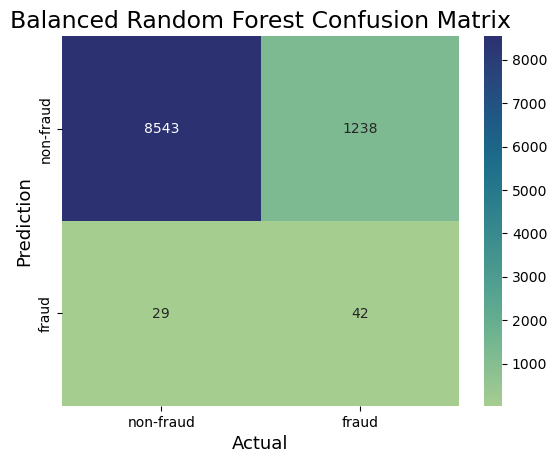

In [53]:
visualize_cm(make_cm_df(predictions_brf), "Balanced Random Forest Confusion Matrix")

#### Choosing an Algorithm

Looking at the different evaluation metrics we see that most balanced performance on both labels is with **Random Forest**.

Let's check the score for our test set for the classifier we choose.

In [54]:
rf.score(features_test, labels_test)

0.989952298792246

In [55]:
predictions_test = rf.predict(features_test)

#### Requirements

We have requirement for not more than 2% of total amount of transactions for predicted frauds' amounts. Let's have a look at the total amounts of our dataset here.

In [56]:
# Calculate the total transactions amount in the test set

total_amount = sum(f_test.f_00.to_numpy())
total_amount

151746829.0

In [57]:
# Calculate the acceptable amount of 2% for fraudulent transactions
MARGIN_PERC = 0.02

fraud_margin = MARGIN_PERC*total_amount
fraud_margin

3034936.58

In [58]:
fraud_indices = np.where(predictions_test == 1)[0]
fraud_indices

array([ 182,  468,  506,  754,  990, 1080, 1597, 2392, 2964, 3002, 3016,
       3337, 3552, 3561, 3562, 3904, 4786, 5216, 5791, 6283, 6338, 6420,
       6756, 6979, 7538, 8802, 9153, 9516, 9534, 9835], dtype=int64)

In [59]:
pred_amounts_list = f_test.f_00.to_list()
type(pred_amounts_list)

list

In [60]:
flagged_values = [pred_amounts_list[i] for i in fraud_indices]
flagged_values

[2679.0,
 2500.0,
 10000.0,
 2500.0,
 5000.0,
 1000.0,
 5000.0,
 2500.0,
 3000.0,
 5000.0,
 20000.0,
 1500.0,
 5000.0,
 1000.0,
 2500.0,
 1995.0,
 2000.0,
 1500.0,
 2000.0,
 5000.0,
 2000.0,
 6000.0,
 2500.0,
 22500.0,
 10000.0,
 1000.0,
 5500.0,
 500.0,
 525.0,
 2500.0]

In [61]:
req = "Requirement passed!" if fraud_margin > sum(flagged_values) else "Please go back and change model performance."
req

'Requirement passed!'

#### Explainability of the model

It is important for out compliance team to have explainability of the model. Let's create some.

In [62]:
rf.feature_importances_

array([0.0216382 , 0.03287311, 0.10074853, 0.05529407, 0.05587451,
       0.21104291, 0.03934231, 0.02844976, 0.02127881, 0.02638872,
       0.02165367, 0.02234839, 0.02567707, 0.02644291, 0.00880906,
       0.02073945, 0.01660673, 0.02135742, 0.01696535, 0.0241223 ,
       0.0270257 , 0.02347007, 0.01992916, 0.01922923, 0.01870503,
       0.02834216, 0.02615155, 0.03949382])

There is no significant difference between the features in terms of importance. However "f_04" and "f_01" are a bit more important than the rest attributes for the model.

In [63]:
# Permutation importances check

permutation_importance(rf, features_train, labels_train)

{'importances_mean': array([6.55827299e-04, 1.28979369e-03, 4.59079109e-03, 2.60144829e-03,
        2.18062577e-03, 4.55799973e-03, 9.67345266e-04, 1.00560186e-03,
        6.72222981e-04, 5.84779341e-04, 8.19784124e-05, 2.84191829e-04,
        4.48148654e-04, 8.30714578e-04, 2.73261375e-05, 4.64544337e-04,
        4.26287744e-04, 1.09304550e-04, 1.63956825e-04, 3.71635469e-04,
        6.61292526e-04, 5.30127067e-04, 1.74887280e-04, 6.55827299e-05,
        1.69422052e-04, 7.10479574e-04, 6.33966389e-04, 1.64503347e-03]),
 'importances_std': array([1.06536897e-04, 1.56881542e-04, 1.24626362e-04, 1.84850767e-04,
        1.22694053e-04, 1.65227123e-04, 1.33870187e-05, 8.36019049e-05,
        1.14117300e-04, 6.37349572e-05, 5.73197895e-05, 1.33870187e-05,
        7.84407711e-05, 9.86772515e-05, 0.00000000e+00, 3.86449942e-05,
        2.78673016e-05, 1.72825668e-05, 2.99342838e-05, 5.06824347e-05,
        7.20913019e-05, 2.18609100e-05, 4.08980176e-05, 2.18609100e-05,
        5.29873464e-05,

From permutation importances we see that with slight higher importance for the model are columns: from "f_00" to "f_05" incl. and also "f_26".  

#### Visualization of one of the trees in the Random Forest

In [64]:
from sklearn.tree import export_graphviz
import pydot

In [65]:
f_test.columns

Index(['id', 'f_00', 'f_01', 'f_02', 'f_03', 'f_04', 'f_05', 'f_06', 'f_07',
       'f_08', 'f_09', 'f_10', 'f_11', 'f_12', 'f_13', 'f_14', 'f_15', 'f_16',
       'f_17', 'f_18', 'f_19', 'f_20', 'f_21', 'f_22', 'f_23', 'f_24', 'f_25',
       'f_26'],
      dtype='object')

In [66]:
# Plot the first tree of the Random Forest

# Extract an individual decision tree from the Random Forest
individual_tree = rf.estimators_[0] 

# Export the decision tree as a DOT file
export_graphviz(individual_tree,
                out_file = "individual_tree.dot",
                feature_names = f_test.columns,
                class_names = ["0", "1"],
                rounded = True,
                filled = True)

# Convert the DOT file to a PNG image using Graphviz
(graph,) = pydot.graph_from_dot_file("individual_tree.dot")

In [67]:
# Display in jupyter notebook

from IPython.display import Image
Image(filename = "individual_tree.png")